In [1]:
''' 1. module import '''
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델 설계를 위한 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    
else:
    DEVICE = torch.device('cpu')
    
print('using pytorch version :',torch.__version__, '\nDevice :',DEVICE)

using pytorch version : 1.9.0 
Device : cpu


In [3]:
BATCH_SIZE = 32 # Mini-Batch 1개에 32개의 데이터로 구성. 미니배치 1개 단위로 역전파를 이용해 AE의 가중값을 업데이트 할 예정
EPOCHS = 1 # 전체 데이터셋을 10회 반복하여 학습

In [4]:
''' 3. FashionMINIST 데이터 다운로드 '''
train_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST", train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST", train = False, download = True, transform = transforms.ToTensor())

# 다운 받은 데이터 셋 미니배치 단위로 저장
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True) 
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

C:\Users\user\anaconda3\envs\PyTorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
train_dataset
len(train_dataset)

60000

In [6]:
len(test_dataset)

10000

In [7]:
len(train_loader)

1875

In [8]:
len(test_loader)

313

In [9]:
len(train_loader.dataset)

60000

In [10]:
len(test_loader.dataset)

10000

X_train: torch.Size([32, 1, 28, 28]) 
type: torch.FloatTensor

y_train: torch.Size([32]) 
type: torch.LongTensor


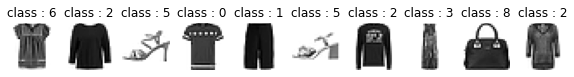

In [11]:
''' 4. 데이터 확인 '''
for (X_train, y_train) in train_loader:
    print('X_train:',X_train.size() ,'\ntype:',X_train.type())
    print('\ny_train:',y_train.size() ,'\ntype:',y_train.type())
    break
    
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28,28), cmap = "gray_r")
    plt.title('class : '+str(y_train[i].item()))

In [12]:
''' 5. AutoEncoder(AE) 모델 설계 '''
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        # 인코더 정의
        # nn.Sequential을 활용하여 인코더 단위를 한 번에 정의
        self.encoder = nn.Sequential(
                                    nn.Linear(28 * 28, 512),
                                    nn.ReLU(),
                                    nn.Linear(512,256),
                                    nn.ReLU(),
                                    nn.Linear(256,32))
        
        
        # 디코더 정의
        # nn.Sequential을 활용하여 디코더 단위를 한 번에 정의
        self.decoder = nn.Sequential(
                                    nn.Linear(32,256),
                                    nn.ReLU(),
                                    nn.Linear(256,512),
                                    nn.ReLU(),
                                    nn.Linear(512,28*28))
        
    # 인코더와 디코더에 대해 Forward Propagation 정의. 
    # 설계한 AE의 인코더와 디코더에 데이터를 입력했을 때 Output을 계산하기까지의 과정
    def forward(self, x):
        encoded = self.encoder(x) # 이미지 데이터를 사전에 정의한 인코더의 input으로 이용하여 Latent Variable Vector를 생성
        decoded = self.decoder(encoded) # Encoded를 디코더의 Input으로 이용
        return encoded, decoded

In [13]:
''' 6. Optimizer, Objective Function 설정 '''
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # 파라미터 업데이트. Optimizer은 Adam. 
criterion = nn.MSELoss()  # Loss 함수는 mse

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [14]:
''' 7. AE 모델 학습을 진행할 때 사용할 함수 정의(학습 데이터에 대한 모델 성능 확인)'''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    
    # 미니 배치 단위로 학습 진행
    for batch_idx, (image,_) in enumerate(train_loader): # 기존 Label 값은 사용되지 않으므로 _를 이용해 생략
        image = image.view(-1, 28 * 28).to(DEVICE) # 2차원 이미지 데이터를 1차원 데이터로 재구성해 할당. 인코더의 input값
        target = image.view(-1, 28 * 28).to(DEVICE) # 2차원 이미지 데이터를 1차원 데이터로 재구성. 디코더의 output과 비교 예정
        
        optimizer.zero_grad() # grad 초기화
        encoded, decoded = model(image) # output 계산
        
        loss = criterion(decoded, target) # MSE
        loss.backward() # grad 계산하고 파라미터에 할당
        optimizer.step() # 최적화 진행. 파라미터 업데이트
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)] \tTrain Loss: {:.6f}".format(Epoch, batch_idx * len(image), 
                                                                                len(train_loader.dataset),
                                                                                100 * batch_idx / len(train_loader), 
                                                                                loss.item()))

In [15]:
len(test_loader) # 총 313개의 미니배치가 존재함

313

In [16]:
''' 8. 학습 과정에서 검증 데이터에 대한 모델 성능 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image = [] # 실제 이미지 데이터 저장 리스트
    gen_image = [] # AE를 통해 생성되는 이미지 데이터 저장 리스트
    
    with torch.no_grad(): # 파라미터 업데이트 억제
        for image, _ in test_loader:
            image = image.view(-1, 28*28).to(DEVICE) # 28*28 크기의 1차원 데이터(픽셀 값을 한 줄로 줄세우기?)로 재구성
            target = image.view(-1, 28*28).to(DEVICE)
            
            encoded, decoded = model(image) # output 계산
            
            test_loss += criterion(decoded, target).item() # 실제 이미지와 생성된 이미지 사이의 MSE 계산
            real_image.append(image.to("cpu"))
            gen_image.append(decoded.to("cpu"))
            
    test_loss /= len(test_loader.dataset) # 평균 loss 계산
    return test_loss, real_image, gen_image 

Train Epoch: 1 [0/60000(0%)] 	Train Loss: 0.252008
Train Epoch: 1 [6400/60000(11%)] 	Train Loss: 0.029653
Train Epoch: 1 [12800/60000(21%)] 	Train Loss: 0.023122
Train Epoch: 1 [19200/60000(32%)] 	Train Loss: 0.019710
Train Epoch: 1 [25600/60000(43%)] 	Train Loss: 0.019846
Train Epoch: 1 [32000/60000(53%)] 	Train Loss: 0.017099
Train Epoch: 1 [38400/60000(64%)] 	Train Loss: 0.014755
Train Epoch: 1 [44800/60000(75%)] 	Train Loss: 0.017930
Train Epoch: 1 [51200/60000(85%)] 	Train Loss: 0.015183
Train Epoch: 1 [57600/60000(96%)] 	Train Loss: 0.013678

[EPOCH : 1],	Test Loss: 0.0005


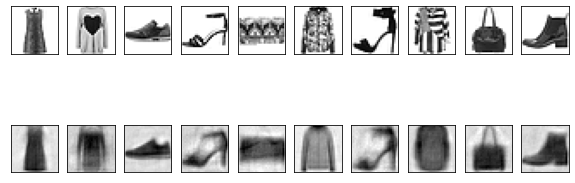

In [17]:
''' 9. AE 모델 학습 실행'''
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200) # 모델 훈련
    test_loss, real_image, gen_image = evaluate(model, test_loader) # 모델 성능 평가
    print("\n[EPOCH : {}],\tTest Loss: {:.4f}".format(Epoch, test_loss))
    f,a = plt.subplots(2, 10, figsize = (10,4))
    
    # 진행 과정 모니터링
    for i in range(10):
        img = np.reshape(real_image[312][i],(28,28)) # 1차원 데이터를 다시 2차원으로 만들기
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
        
    for i in range(10):
        img = np.reshape(gen_image[312][i],(28,28)) # 1차원 데이터를 다시 2차원으로 만들기
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())

In [18]:
real_image[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [19]:
real_image[0].size()

torch.Size([32, 784])

In [20]:
gen_image[0].size()

torch.Size([32, 784])